# Modelo Preditivo de Preço de Imóveis
## Introdução
A precificação de imóveis em Atibaia é um processo manual, subjetivo e demorado, levando a inconsistências e perda de oportunidades de negócio. Este projeto ataca o problema desenvolvendo um modelo de Machine Learning que fornece uma avaliação de preço instantânea e baseada em dados, com o objetivo de:

Reduzir o tempo de avaliação de imóveis de horas para segundos.

Estabelecer um baseline de preço objetivo para negociações.

Identificar imóveis potencialmente sub ou supervalorizados."

## Índice
1. Introdução
2. Carregamento e Limpeza Inicial dos Dados
3. Análise Exploratória e Engenharia de Features
4. [Treinando Modelo](#treinando-modelo)
5. Avaliação e Análise de Erros
6. Conclusão Final

## 2. Carregamento e Limpeza Inicial dos Dados.

Nesta seção, realizamos a importação das bibliotecas essenciais para a análise e o carregamento do dataset. Em seguida, aplicamos uma limpeza inicial, removendo colunas que não agregam valor preditivo ao modelo, como identificadores, referências e dados textuais irrelevantes.

In [ ]:
# --- Importação das Bibliotecas ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Carregamento e Limpeza Inicial ---

# Carrega o arquivo
imoveis = pd.read_excel("imoveis-30-07-2025.xls")
print(f"Formato original do dataset: {imoveis.shape}")

# Converte a coluna de data para o formato datetime
imoveis['Data de cadastro'] = pd.to_datetime(imoveis['Data de cadastro'], dayfirst=True)

# Define a lista de colunas e remove elas na limpeza inicial
features_para_remover = [
    'Status', 'Referência', 'Referência alternativa', 'Compl.', 'Edf. / Cond.', 
    'Endereço', 'R$ Venda M²', 'R$ Locação M²', 'Data de atualização', 'Fotos', 
    'R$ Locação', 'Captador(es)', 'Promotor(es)', 'Indicador(es)', 'Marcador(es)', 
    'Permuta por'
]

imoveis = imoveis.drop(columns=features_para_remover)

print(f"Formato do dataset após limpeza inicial: {imoveis.shape}")

# Exibe as primeiras linhas para verificação
imoveis.head()

## 3. Análise Exploratória e Engenharia de Features

Nesta seção, transformamos os dados limpos em features robustas para o modelo. O processo foi dividido em várias etapas:

* **Tratamento de Categorias Raras:** Agrupamos categorias com poucas amostras (em `Cidade`, `Finalidade` e `Bairro`) para evitar ruído e ajudar o modelo a generalizar.
* **Codificação (One-Hot Encoding):** Convertemos as variáveis categóricas em um formato numérico que o modelo pode processar.
* **Filtragem e Criação de Features:** Filtramos o dataset para focar em imóveis de venda, removemos outliers de preço e área, e criamos novas features inteligentes, como a `Proporcao_Suites`.
* **Transformação Logarítmica:** Aplicamos a transformação de log nas variáveis de preço e área para normalizar suas distribuições e estabilizar o modelo, resolvendo parte do problema de heterocedasticidade

### 3.1 Tratamento de Categorias Raras

In [ ]:
# Agrupando cidades com menos de 10 imóveis na categoria 'Outra'
contagem_cidades = imoveis['Cidade'].value_counts()
cidades_raras = contagem_cidades[contagem_cidades < 10].index
imoveis['Cidade'] = imoveis['Cidade'].replace(cidades_raras, 'Outra')

# Agrupando finalidades com menos de 30 imóveis na categoria 'Outra'
contagem_finalidade = imoveis['Finalidade'].value_counts()
finalidades_raras = contagem_finalidade[contagem_finalidade < 30].index
imoveis['Finalidade'] = imoveis['Finalidade'].replace(finalidades_raras, 'Outra')

# Agrupando bairros com menos de 5 imóveis na categoria 'Outro_Bairro'
contagem_bairros = imoveis['Bairro'].value_counts()
bairros_raros = contagem_bairros[contagem_bairros < 5].index
imoveis['Bairro'] = imoveis['Bairro'].replace(bairros_raros, 'Outro_Bairro')

print("Contagem de cidades após agrupamento:")
print(imoveis['Cidade'].value_counts())
print("\nContagem de bairros após agrupamento (Top 5):")
print(imoveis['Bairro'].value_counts().head(5))

### 3.2 Codificação das Variáveis Categóricas

In [ ]:
imoveis = pd.get_dummies(imoveis, columns=["Tipo", "Finalidade", "Bairro", "Cidade"])
print("\nFormato do dataset após get_dummies:", imoveis.shape)

### 3.3 Filtragem, Criação de Features e Transformação Final

In [ ]:
# 1. Filtrar o DataFrame para focar apenas em imóveis de venda
df_vendas = imoveis[imoveis["R$ Venda"] > 0].copy()

# 2. Remover outliers extremos de área e preço
df_vendas = df_vendas[df_vendas["Área total"] < 30000]
df_vendas = df_vendas[df_vendas["R$ Venda"] <= 4000000]

# 3. Criar a feature 'Ano de cadastro' e remover a original
df_vendas["Ano de cadastro"] = df_vendas["Data de cadastro"].dt.year
df_vendas = df_vendas.drop(columns=["Data de cadastro"])

# 4. Aplicar a transformação de log nas colunas de dinheiro e área
col_para_log = ["R$ Venda", "R$ Cond.", "R$ Iptu", "Área total", "Área"]
for coluna in col_para_log:
    df_vendas[coluna + "_log"] = np.log1p(df_vendas[coluna])

# 5. Criar as features de interação
df_vendas["Proporcao_Suites"] = df_vendas["Suítes"] / (df_vendas["Dormitórios"] + 1)
df_vendas['Area_por_Dormitorio'] = np.expm1(df_vendas['Área_log']) / (df_vendas['Dormitórios'] + 1)
df_vendas['Proporcao_Area_Construida'] = np.expm1(df_vendas['Área_log']) / (np.expm1(df_vendas['Área total_log']) + 1e-6)

# 6. Remover as colunas originais que foram transformadas
df_vendas = df_vendas.drop(columns=col_para_log)

print(f"\nFormato final do dataset para treinamento: {df_vendas.shape}")
df_vendas.info()

### 3.4 Registro de Experimentos e Conclusões

Durante a etapa de engenharia de features, exploramos e testamos algumas hipóteses para extrair o máximo de performance do modelo. O registro de experimentos é crucial para um processo de otimização metódico.

* **Experimento:** Criação da feature `Area_log_ao_quadrado` para capturar uma relação não-linear entre área e preço.
* **Resultado:** Após o treinamento do modelo com esta nova feature, as métricas de avaliação permaneceram inalteradas.
* **Conclusão:** O experimento indicou que, para este conjunto de dados, a relação entre a área e o preço (após a transformação de log) é predominantemente linear, e a adição do termo quadrático não forneceu nenhum ganho preditivo. A feature foi, portanto, descartada.

`df_vendas['Area_log_ao_quadrado'] = df_vendas['Área_log'] ** 2`

## 4. Modelagem e Treinamento do Modelo
Com o nosso conjunto de dados devidamente limpo, tratado e com novas features criadas, separamos o conjunto de dados para treinamento e teste. Em seguida, treinamos o modelo `XGBoost`, conhecido por sua alta performance em dados tabulares.

In [ ]:
# --- Separação de Features e Alvo ---
# X contém todas as features (características)
# y_log contém o alvo (R$ Venda) transformado por log
X = df_vendas.drop("R$ Venda_log", axis=1)
y_log = df_vendas["R$ Venda_log"]

# --- Divisão em Conjuntos de Treino e Teste ---
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log,
    test_size=0.3, random_state=101
)

# --- Treinamento do Modelo XGBoost ---
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Treina o modelo com os dados de treino
model_xgb.fit(X_train, y_train_log)

print("✅ Modelo treinado com sucesso!")
print(f"O modelo foi treinado com {X_train.shape[0]} exemplos de imóveis.")
print(f"O modelo será testado com {X_test.shape[0]} exemplos que nunca viu.")

## 5. Avaliação e Análise de Erros

Após o treinamento, avaliamos a performance do modelo utilizando o conjunto de teste, que contém dados que o modelo nunca viu. As previsões, que estavam em escala logarítmica, foram convertidas de volta para a escala de Reais para a interpretação das métricas de erro e a visualização dos resultados.

In [ ]:
# --- Realizando as Previsões ---
predictions_log = model_xgb.predict(X_test)

# --- Revertendo a Transformação de Log para Avaliação ---
y_test_reais = np.expm1(y_test_log)
previsoes_reais = np.expm1(predictions_log)

# --- Cálculo das Métricas de Performance ---
r2 = r2_score(y_test_reais, previsoes_reais)
mae = mean_absolute_error(y_test_reais, previsoes_reais)
rmse = np.sqrt(mean_squared_error(y_test_reais, previsoes_reais))

print("--- Métricas Finais do Modelo XGBoost ---")
print(f"R² (Coeficiente de Determinação): {r2:.2%}")
print(f"MAE (Erro Médio Absoluto): R$ {mae:,.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:,.2f}")

R2: 73.02%
É a porcentagem da variação dos preços que o modelo explicou com base nas features

MAE: R$ 283,832.54
(Em média, as previsões do modelo erram este valor, para mais ou para menos)

RMSE: R$ 417,780.10
(Mede o erro típico, mas penalizando erros muito grandes com mais força)


### 5.1 Visualização: Previsão vs. Real

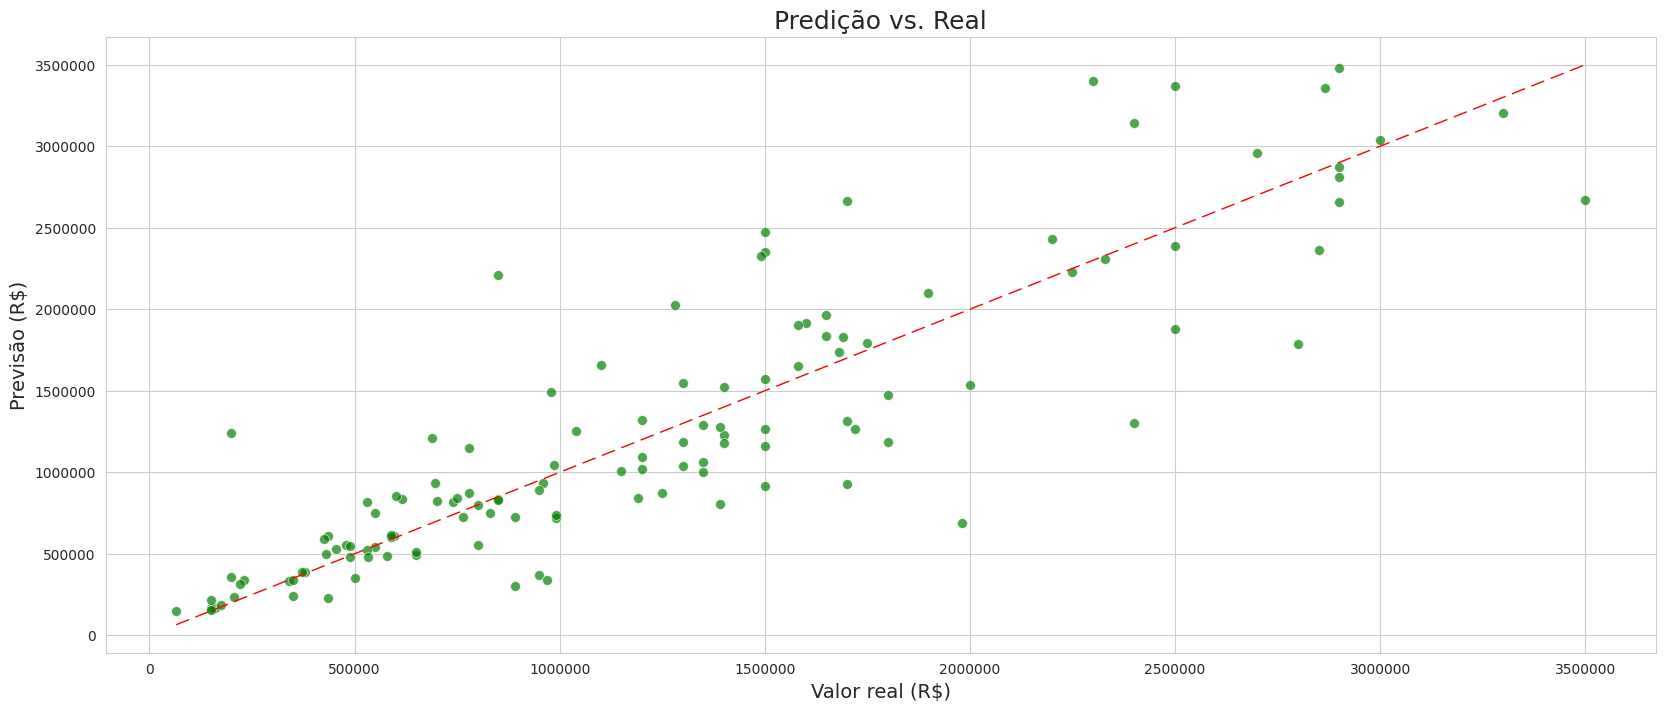

In [ ]:
# O gráfico de dispersão é a melhor forma de visualizar a performance do modelo.
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")

# Cria o scatter plot
sns.scatterplot(x=y_test, y=predictions, color="green", alpha=0.7, s=50)

# Adiciona a linha de referência (modelo perfeito)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', dashes=(10, 5), linewidth=1)

# Customização do gráfico
plt.title("Previsão do Modelo vs. Valor Real", fontsize=18)
plt.xlabel("Valor real (R$)", fontsize=14)
plt.ylabel("Previsão (R$)", fontsize=14)
plt.ticklabel_format(style='plain', axis='both')
plt.grid(True)

### 5.2 Análise dos maiores erros

Para entender as limitações do modelo, realizamos uma análise dos 5 casos em que ele cometeu os maiores erros. Isso nos ajuda a identificar padrões e possíveis áreas para melhorias futuras.

In [23]:
# (Relembrando o código)
df_erros = pd.DataFrame({
    'Preco_Real': y_test,
    'Previsao': predictions,
    'Erro_Absoluto': abs(y_test - predictions)
})
piores_previsoes = df_erros.sort_values(by='Erro_Absoluto', ascending=False)
#print(piores_previsoes.head(10))

### Padrão
R2: 63.73%
É a porcentagem da variação dos preços que o modelo explicou com base nas features

MAE: R$ 346,921.05
(Em média, as previsões do modelo erram este valor, para mais ou para menos)

RMSE: R$ 718,679.86
(Mede o erro típico, mas penalizando erros muito grandes com mais força)

### Proporção Suíte por dormitório
R2: 64.45%
É a porcentagem da variação dos preços que o modelo explicou com base nas features

MAE: R$ 344,797.34
(Em média, as previsões do modelo erram este valor, para mais ou para menos)

RMSE: R$ 711,534.84
(Mede o erro típico, mas penalizando erros muito grandes com mais força)

### Com Área por dormitório
R2: 64.26%
É a porcentagem da variação dos preços que o modelo explicou com base nas features

MAE: R$ 347,815.77
(Em média, as previsões do modelo erram este valor, para mais ou para menos)

RMSE: R$ 713,461.42
(Mede o erro típico, mas penalizando erros muito grandes com mais força)

### Quadrado do Log da Área, para o modelo entender melhor as curvas
R2: 64.45%
É a porcentagem da variação dos preços que o modelo explicou com base nas features

MAE: R$ 344,797.34
(Em média, as previsões do modelo erram este valor, para mais ou para menos)

RMSE: R$ 711,534.84
(Mede o erro típico, mas penalizando erros muito grandes com mais força)


## heterocedasticidade
